In this project, I'll use Tensorflow and Keras to build, train and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem called multiclass classification problem.

# Imports and dataset

## Loading the data from Kaggle

In [1]:
from google.colab import files

# connecting to Kaggle account
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedroalvess","key":"049979621a39cd92264bf7b82dc277e0"}'}

In [2]:
# installing Kaggle API Client

!pip install -q kaggle

In [3]:
# moving file to Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# permission change to avoid warning on Kaggle startup
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# creating directory and changing the working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# finding the dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1478          6  0.1764706        


In [6]:
# downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 98% 679M/691M [00:02<00:00, 309MB/s]
100% 691M/691M [00:02<00:00, 312MB/s]
/content


In [7]:
# Unzipping and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

## Imports

In [8]:
#importing libraries

# data wrangling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# machine learning

from tqdm import tqdm

# sci-kit learn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# keras and tensorflow
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Data Processing

In [9]:
# read labels
labels_all = pd.read_csv('dog_dataset/labels.csv')

In [10]:
# checking the file
labels_all.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# checking shape of file
labels_all.shape

(10222, 2)

In [12]:
# visualize the number of breeds
labels_all['breed'].value_counts().head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [13]:
# select the most frequent 3 breeds for classification
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'afghan_hound']

# filtering dataframe by breeds
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()

In [14]:
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [15]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

In [16]:
# reading and converting image to np array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# printing train image and one hot encoding shape and size

print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One hot enconded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 359/359 [00:01<00:00, 288.94it/s]


Train Images shape:  (359, 224, 224, 3)  size: 54,039,552
One hot enconded output shape:  (359, 3)  size: 1,077


# Building the model

In [24]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 16)      

After definind the neural network archtechture, we've found the number of 162,619 params.

In [25]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.3, random_state = 42)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2, random_state = 42)

In [26]:
# training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_test, Y_test))

Epoch 1/100
2/2 [==============================] - 2s 532ms/step - loss: 4.8939 - accuracy: 0.3750 - val_loss: 4.8747 - val_accuracy: 0.3241
Epoch 2/100
2/2 [==============================] - 1s 300ms/step - loss: 4.8666 - accuracy: 0.4150 - val_loss: 4.8503 - val_accuracy: 0.3241
Epoch 3/100
2/2 [==============================] - 1s 316ms/step - loss: 4.8409 - accuracy: 0.4250 - val_loss: 4.8254 - val_accuracy: 0.3056
Epoch 4/100
2/2 [==============================] - 1s 310ms/step - loss: 4.8159 - accuracy: 0.4200 - val_loss: 4.8009 - val_accuracy: 0.3056
Epoch 5/100
2/2 [==============================] - 1s 311ms/step - loss: 4.7911 - accuracy: 0.4100 - val_loss: 4.7769 - val_accuracy: 0.3056
Epoch 6/100
2/2 [==============================] - 1s 311ms/step - loss: 4.7657 - accuracy: 0.4000 - val_loss: 4.7537 - val_accuracy: 0.3148
Epoch 7/100
2/2 [==============================] - 1s 313ms/step - loss: 4.7411 - accuracy: 0.4050 - val_loss: 4.7303 - val_accuracy: 0.3056
Epoch 8/100
2

In [27]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

4/4 [==============================] - 0s 32ms/step - loss: 3.2797 - accuracy: 0.6481
Accuracy over the test set: 
  64.81 %


In [28]:
df = pd.DataFrame(history.history) 

In [29]:
fig = px.line(data_frame = df, 
              y = ['accuracy', 'val_accuracy'],
              template = 'plotly_dark',
              markers = True
              )

fig.update_layout(
    title = {
        'text': 'Model Accuracy'},
    xaxis_title = 'Epochs',
    yaxis_title = 'Accuracy',
    width = 1200,
    height = 500,
    font_family="Arial",
    font_color="White",
    title_font_family="Arial",
    title_font_color= "White")

fig.show()

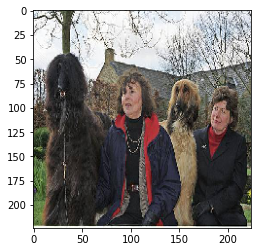

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [36]:
# plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# finding max value from predition list and comaparing original value vs predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[1])])

In [37]:
model.save('dog_breed.h5')